In [87]:
import numpy as np

class ContinuousJumpModel:
    """
    Continuous Jump Model with Soft State Assignments
    """

    def fixed_states_optimize(self, y, s, k):
        T, n_features = y.shape
        theta = np.zeros((k, n_features))

        for state in range(k):
            weights = s[:, state]
            theta[state] = np.sum(y * weights[:, np.newaxis], axis=0) / np.sum(weights)

        return theta

    def generate_loss_matrix(self, y, theta):
        diff = y[:, np.newaxis, :] - theta[np.newaxis, :, :]
        loss = 0.5 * np.sum(diff**2, axis=-1)
        return loss
    
    def generate_C(self, K, grid_size = 0.05):
        N = int(1 / grid_size) ** K
        # Generate a KxN matrix with uniform random values
        matrix = np.random.rand(K, N)
        # Normalize each column so that they sum to 1
        matrix /= matrix.sum(axis=0)
        return matrix

    def fixed_theta_optimize(self, lossMatrix, C, lambda_):
        T, K = lossMatrix.shape
        _, N = C.shape

        L_tilde = lossMatrix @ C
        Lambda = np.array([[lambda_ / 4 * np.linalg.norm(c_i - c_j, ord=1)**2 for c_j in C.T] for c_i in C.T])

        V_tilde = np.zeros((T, N))
        V_tilde[0, :] = L_tilde[0, :]

        for t in range(1, T):
            for i in range(N):
                V_tilde[t, i] = L_tilde[t, i] + np.min(V_tilde[t-1, :] + Lambda[:, i])

        s_hat = np.zeros((T, K))
        i_hat = np.argmin(V_tilde[-1, :])
        v_hat = np.min(V_tilde[-1, :])
        s_hat[-1] = C[:, i_hat]

        for t in range(T-2, -1, -1):
            i_hat = np.argmin(V_tilde[t, :] + Lambda[:, i_hat])
            s_hat[t] = C[:, i_hat]

        return s_hat, v_hat

In [101]:
from quantbullet.research.jump_model import DiscreteJumpModel, TestingUtils, FeatureGenerator, SimulationGenerator
np.random.seed(999)

model = DiscreteJumpModel()
transition_matrix, norm_params = TestingUtils().daily()
sim_states, sim_returns = SimulationGenerator().run(
    steps=1000, transition_matrix=transition_matrix, norm_params=norm_params
)
enriched_returns = FeatureGenerator().enrich_features(sim_returns)
enriched_returns = FeatureGenerator().standarize_features(enriched_returns)

# initialize centroids using k-means++
centroids = model.initialize_kmeans_plusplus(enriched_returns, 2)
cur_s = model.classify_data_to_states(enriched_returns, centroids)
second_col = 1 - cur_s
cur_s = np.column_stack((cur_s, second_col))


09-20 04:48:30 INFO Step 1: Initial (stationary) distribution: [0.84997341 0.15002659]
09-20 04:48:30 INFO Step 2: Simulated states: Counter({0: 633, 1: 368})
09-20 04:48:30 INFO Step 3: Generate simulated return data conditional on states.


In [114]:
# the coordinate descent algorithm
from tqdm import tqdm

ctsJump = ContinuousJumpModel()

tol = 100
max_iter = 100

prev_loss = float('inf')

for _ in tqdm(range(max_iter)):
    cur_theta = ctsJump.fixed_states_optimize(enriched_returns, cur_s, 2)
    lossMatrix = ctsJump.generate_loss_matrix(enriched_returns, cur_theta)
    C = ctsJump.generate_C(2)
    cur_s, cur_loss = ctsJump.fixed_theta_optimize(lossMatrix, C, 100)

    print(cur_loss)

    # Check for convergence
    if abs(prev_loss - cur_loss) < tol:
        break

    prev_loss = cur_loss

  1%|          | 1/100 [00:03<05:18,  3.22s/it]

5828.400184908099


  1%|          | 1/100 [00:06<10:28,  6.35s/it]

5854.666432434279


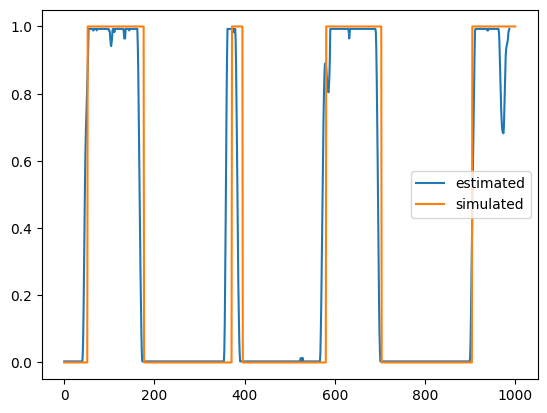

In [116]:
import matplotlib.pyplot as plt
plt.plot(cur_s[:, 0], label='estimated')
plt.plot(sim_states, label='simulated')
plt.legend()